In [32]:
import torch
import torchvision.transforms as transforms
from torchvision.models import densenet121, resnet50
import os
import numpy as np
import faiss
from PIL import Image
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim


In [52]:
# Initialize ResNet
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = resnet50(pretrained=True)  

# Freeze early layers
for param in model.parameters():
    param.requires_grad = False

# Replace the last layer with a new one
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(num_ftrs, 1024),
    nn.LayerNorm(1024),  # Replace BatchNorm1d with LayerNorm
    nn.ReLU(),
    nn.Dropout(0.4),  
    nn.Linear(1024, 512)  
)

# Unfreeze last few layers for fine-tuning
for param in list(model.parameters())[-20:]:  
    param.requires_grad = True

# Use AdamW optimizer with weight decay
optimizer = optim.AdamW(model.parameters(), lr=5e-5, weight_decay=1e-4)  

# Learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)  

# Ensure model is in eval mode before inference
model.eval()

os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"


In [53]:
# Image transformation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [54]:
# Function to generate embedding using ResNet
def generate_embedding(image_path):
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        embedding = model(image).squeeze(0).cpu().numpy()
    return embedding


C:\Users\qures\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Mean Cosine Similarity for ResNet50 embeddings: 0.9876
Mean Cosine Similarity for DenseNet121 embeddings: 0.9897


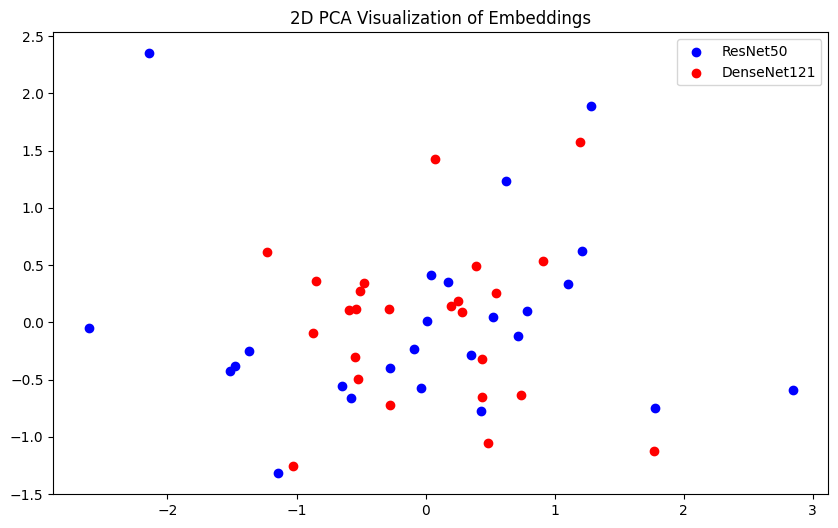

In [36]:
import os
import torch
import numpy as np
from PIL import Image
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Assuming models and device are already defined
# Example: model1 = ResNet50, model2 = DenseNet121
# Assuming transform and device are defined as well

# Function to generate embedding using ResNet
def generate_embedding_resnet(image_path):
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        model1 = resnet50(pretrained=True)  # Replace DenseNet with ResNet
        embedding = model1(image).squeeze(0).cpu().numpy()  # Use ResNet50 model
    return embedding

# Function to generate embedding using DenseNet
def generate_embedding_densenet(image_path):
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        model2 = densenet121(pretrained=True)
        embedding = model2(image).squeeze(0).cpu().numpy()  # Use DenseNet121 model
    return embedding

# Directory path where your dataset is stored
dataset_dir = r"C:\Users\qures\OneDrive\Desktop\Matching Images Embeddings\Images"

# Store embeddings
embeddings_resnet = []
embeddings_densenet = []

# Iterate over all subfolders in the dataset directory
for folder_name in os.listdir(dataset_dir):
    folder_path = os.path.join(dataset_dir, folder_name)
    
    # Only process directories (subfolders)
    if os.path.isdir(folder_path):
        for image_name in os.listdir(folder_path):
            image_path = os.path.join(folder_path, image_name)
            
            if image_name.endswith(('.jpg', '.jpeg', '.png')):
                # Generate embeddings for each image using both models
                embedding_resnet = generate_embedding_resnet(image_path)
                embedding_densenet = generate_embedding_densenet(image_path)
                
                # Append the embeddings to the list
                embeddings_resnet.append(embedding_resnet)
                embeddings_densenet.append(embedding_densenet)

# Convert list of embeddings to NumPy arrays
embeddings_resnet = np.array(embeddings_resnet)
embeddings_densenet = np.array(embeddings_densenet)

# Compute cosine similarity between the embeddings from both models
cos_sim_resnet = cosine_similarity(embeddings_resnet)  # Similarity for ResNet50 embeddings
cos_sim_densenet = cosine_similarity(embeddings_densenet)  # Similarity for DenseNet121 embeddings

# If you want to check overall similarity, compute the mean cosine similarity
mean_cos_sim_resnet = np.mean(cos_sim_resnet)
mean_cos_sim_densenet = np.mean(cos_sim_densenet)

print(f"Mean Cosine Similarity for ResNet50 embeddings: {mean_cos_sim_resnet:.4f}")
print(f"Mean Cosine Similarity for DenseNet121 embeddings: {mean_cos_sim_densenet:.4f}")

# Perform PCA for dimensionality reduction (Visualize the embeddings)
pca = PCA(n_components=2)

# Reduce dimensions to 2D for visualization
embeddings_resnet_2d = pca.fit_transform(embeddings_resnet)
embeddings_densenet_2d = pca.fit_transform(embeddings_densenet)

# Plot the embeddings to visually compare
plt.figure(figsize=(10, 6))
plt.scatter(embeddings_resnet_2d[:, 0], embeddings_resnet_2d[:, 1], color='blue', label='ResNet50')
plt.scatter(embeddings_densenet_2d[:, 0], embeddings_densenet_2d[:, 1], color='red', label='DenseNet121')
plt.title("2D PCA Visualization of Embeddings")
plt.legend()
plt.show()


In [55]:
# Function to save embeddings and image names
def save_embeddings_and_names(dataset_path):
    embeddings = []
    image_names = []

    # Process all images in the dataset
    for category in os.listdir(dataset_path):
        category_path = os.path.join(dataset_path, category)
        if os.path.isdir(category_path):
            for img_file in os.listdir(category_path):
                img_path = os.path.join(category_path, img_file)
                embedding = generate_embedding(img_path)
                embeddings.append(embedding)
                image_names.append(f"{category}/{img_file}")
    
    embeddings = np.array(embeddings)
    image_names = np.array(image_names)
    
    # Save embeddings and image names
    np.save('image_embeddings.npy', embeddings)
    np.save('image_names.npy', image_names)
    print(f"Saved {len(image_names)} embeddings and image names.")


In [56]:
# Load saved embeddings and image names
def load_embeddings_and_names():
    saved_embeddings = np.load('image_embeddings.npy')
    image_names = np.load('image_names.npy')
    return saved_embeddings, image_names

In [57]:
# Initialize FAISS index and add saved embeddings
def initialize_faiss_index(saved_embeddings):
    embedding_dim = saved_embeddings.shape[1]  # Get the embedding dimension from saved embeddings
    faiss_index = faiss.IndexFlatL2(embedding_dim)  # Using L2 distance (Cosine similarity can also be used)
    faiss_index.add(saved_embeddings)  # Add saved embeddings to FAISS index
    return faiss_index

In [58]:
# Normalize embeddings to unit vectors (for cosine similarity)
def normalize_embeddings(embeddings):
    return embeddings / np.linalg.norm(embeddings, axis=1, keepdims=True)

In [59]:
# Function to find the most similar image
def find_most_similar_image(input_image_path, faiss_index, image_names):
    input_embedding = generate_embedding(input_image_path)
    input_embedding = input_embedding / np.linalg.norm(input_embedding)  # Normalize input embedding

    # Perform similarity search using FAISS
    distances, indices = faiss_index.search(np.array([input_embedding]), k=1)  # k=1 to get top 1 match

    # Get the most matched image
    matched_image_name = image_names[indices[0][0]]
    return matched_image_name, distances[0][0]

In [60]:
# Main function
def main():
    dataset_path = r"C:\Users\qures\OneDrive\Desktop\Matching Images Embeddings\Images"  # Path to your dataset (5 places each having 5 images)
    
    # Save embeddings and image names to files
    save_embeddings_and_names(dataset_path)

    # Load saved embeddings and image names
    saved_embeddings, image_names = load_embeddings_and_names()

    # Normalize embeddings to unit vectors for cosine similarity
    saved_embeddings = normalize_embeddings(saved_embeddings)

    # Initialize FAISS index and add embeddings
    faiss_index = initialize_faiss_index(saved_embeddings)

    # Test with an input image (user's image)
    input_image_path = r"C:\Users\qures\OneDrive\Desktop\ansu_test.jpg"  # Path to the input image provided by the user
    matched_image_name, distance = find_most_similar_image(input_image_path, faiss_index, image_names)

    # Display the result
    print(f"Most matched image: {matched_image_name} with distance: {distance}")

if __name__ == "__main__":
    main()

Saved 25 embeddings and image names.
Most matched image: Saif_ul_malok/saif_ul_malok_4.jpg with distance: 0.41974759101867676
